# Système de Gestion de Base de Données Relationnelles

### Exercice 1 - ACID

Pour chacun des scénarios suivant dire laquelle des quatre propriété **ACID** est mise en jeu.

1. Une transaction tente d'insérer 20 lignes dans une table. L'insertion de la 19e ligne échoue, à cause d'une contrainte de clé primaire. La transaction est annulée et aucune lignes ne se retrouve dans la table.

**A**CID: **Atomicité** - soit tous les ordres de la transaction sont exécutés soit aucun (si l'un d'eux échoue).

2. On exécute intégralement une transaction, validée par un «COMMIT». La machine exécutant le SGBD subit une panne de courant. Au redémarrage, l'effet de la transaction a bien été pris en compte.

ACI**D**: **Durabilité** - une transaction validée est immédiatement transcrite sur un support de stockage pérenne.

3. Sur une table $T$ contenant une colonne `n` de type INTEGER, on exécute deux transactions, «en même temps». La première ajoute 1 à toutes les cases de la colonne `n` et la seconde retire 1 à ces mêmes cases. Le contenu de la table $T$ après exécution (sans erreur) est le même.

AC**I**D pour **Isolation**: les transactions sont réalisées effectivement l'une après l'autre.

### Exercice 2 - carte perdue à la bibliothèque

On considère la base de données de la bibliothèque. On suppose qu'un utilisateur a perdu sa carte, dont le code barre est '111111111111111'. Un employé lui crée une nouvelle carte, dont le code barre est '22222222222222'. 

Donner une transaction permettant de réaliser le processus de «remplacement de carte».

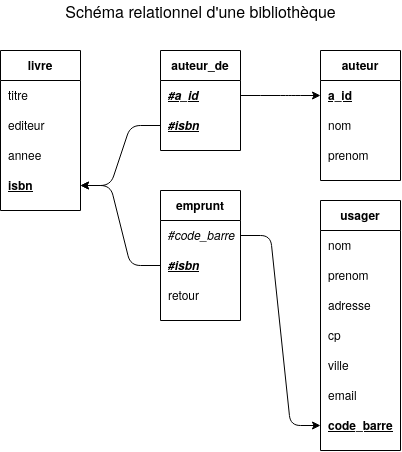

La chose est rendue «ardue» par la contrainte de clé étrangère sur le code barre. Ainsi, on va
1. créer un table temporaire pour conserver les emprunts courants de l'usager, 
2. supprimer ces emprunts de la table emprunt,
3. modifier le code_barre de l'usager,
4. rétablir ses emprunts à partir de la table temporaire,
5. supprimer la table temporaire.

```sql
BEGIN;
  -- sauvegarde des emprunts de l'utilisateur dans une table temporaire tmp
  SELECT * INTO tmp FROM emprunt
      WHERE code_barre = '111111111111111';
  -- suppression des emprunts bloquants
  DELETE FROM emprunts
      WHERE code_barre = '111111111111111';
  -- mise à jour du code barre
  UPDATE usager SET code_barre = '22222222222222'
      WHERE code_barre = '111111111111111';
  -- rétablissement des emprunts avec le code barre adéquat
  INSERT INTO emprunt (SELECT '22222222222222', isbn, retour);
  -- suppression de la table temporaire
  DROP TABLE tmp;
COMMIT;
```

### Exercice 3 - Réservation de billets de trains

Sur un site web de réservation de billets de trains, un usager peut consulter la liste des billets qui répondent à certains critères (destination, date, prix, etc.). Lorsqu'il trouve un billet à sa convenance, il peut le sélectionner puis l'acheter.

On suppose que la base de données du site stocke tous les billets disponibles dans une unique table «billet_a_vendre» où les billets possèdent un attribut «id INTEGER PRIMARY KEY» et d'autres attributs que l'on ne précise pas. Les billets vendus sont stockés dans une table «billet_vendu», ayant le même schéma que «billet_a_vendre». On suppose enfin que la recherche se fait par un simple:

    SELECT id FROM billet_a_vendre WHERE ....;
    
où les critères sont ceux cochés sur le site.

1. Étant donné un identifiant $i$ de billet, donner le code SQL de la transaction qui permet de réaliser l'achat de ce billet.

```sql
BEGIN;
  -- les tables billet_vendu et billet_a_vendre suivent le même schéma
  INSERT INTO billet_vendu VALUES (
      SELECT * FROM billet_a_vendre
      WHERE id = i
  );
  DELETE FROM billet_a_vendre WHERE id = i;
COMMIT;
```

2. Expliquer pourquoi il est possible que quelqu'un trouve un billet à sa convenance, mais qu'au moment de l'achat le billet ne soit plus disponible.

Il suffit que ce billet apparaisse dans la requête d'un autre usager et que celui-ci valide son achat plus rapidement.

3. Pour «corriger» le problème précédent, on décide de mettre la recherche et l'achat dans la même transaction. Quel nouveau problème (bien plus grave) est causé par cette approche?

**Avantage**: premier arrivé, premier servi ... si un utilisateur «voit» le billet, aucun autre ne peut le voir,

**Inconvénient**: si l'usager ne finalise pas son achat, il faut s'en apercevoir pour ramener la base de données dans son état initial ce qui promet de ne pas être de tout repos...

### Exercice 4 - Relevés météos

Considérons une table:

    CREATE TABLE T (id INT PRIMARY KEY, jour DATE, heure TIME, tmp DECIMAL(5,2));

Cette table permet d'enregistrer des relevés de température faits par une sonde. Chaque relevé possède un identifiant unique, le jour du relevé, l'heure du relevé et la température relevée.

1. Supposons données trois valeurs j (un jour), h (une heure) et t (une température). Écrire une transaction qui ajoute la nouvelle entrée en choisissant automatiquement un nouvel identifiant. On pourra, dans un premier temps, considérer qu'il y a des données dans la table T, puis complexifier la transaction pour gérer le cas de la table vide.

Je suppose que la table n'est pas vide:
```sql
BEGIN;
    INSERT INTO T (
        SELECT 1 + max(id) FROM T, 
        j, h, t)
COMMIT;
```

Pour le cas d'une table qui pourrait être vide, on pourrait créer une table temporaire avec une entrée fictive judicieusement initialisée:
```sql
BEGIN;
    CREATE TABLE tmp (i INT);
    INSERT INTO tmp VALUES (-1);
    -- si T est vide, cela insère la valeur NULL dans tmp
    INSERT INTO tmp VALUES (SELECT max(id) FROM T);
    INSERT INTO T (
        SELECT 1 + max(id) FROM tem, 
        j, h, t)
    DELETE TABLE tmp;
COMMIT;
```

2. On considère deux ordres exécutés en **parallèle**:
   - `SELECT min(jour) FROM T WHERE tmp >= 40;` qui renvoie le jour le plus ancien pour lequel la température a dépassé 40°.
   - `UPDATE T SET tmp = tmp * 1.8 + 32;` qui convertit toutes les températures en degrés Farenheit.

   Est-ce que la propriété ACID d'isolation garantit que la requête « `SELECT min...`» renvoie toujours   le 
   même résultat quel que soit l'ordre d'exécution des deux requêtes?

**Non**: ces requêtes «en parallèle» seront réalisées l'une après l'autre (dans un ordre impossible à déterminer) et, selon cet ordre, la réponse sera différente.

### Exercice 5 - Python: Table vers CSV

Écrire un programme Python qui sauvegarde l'intégralité de la table **usager** de *biblio* dans un fichier CSV nommé `usager.csv`.

*Conseils/rappels*:

- CSV (**C**omma **S**eparated **V**alue): simple fichier texte qui contient une ligne par «objet»; les valeurs de ses attributs séparées par une `,` (comma).

- Dans une table, une valeur peut très bien contenir le séparateur `,`, il va donc falloir quoter `"..."` les chaînes,

- Normalement (ce n'est pas obligatoire), la première ligne d'un fichier CSV contient les noms des descripteurs des données (nom des champs de la table). Pour comprendre comment les récupérer , chercher dans la [la doc sur les curseurs](https://www.psycopg.org/docs/cursor.html#cursor) de *psycopg2*,

- Penser à `str.join(<sequence>)` qui assemble une chaîne à partir d'une séquence de chaînes et d'un séparateur. Ex: `"->".join(["a", "b", "c"])` renvoie `"a->b->c"`. 

**Une solution**

In [ ]:
import psycopg2 as pg

conn = pg.connect(database="livres") # ou <initiale>_biblio
cur = conn.cursor()

cur.execute("SELECT * from usager");

with open("usager.csv", "w") as csv:
    # récupération des colonnes pour la première ligne de fichier csv
    # cf https://www.psycopg.org/docs/cursor.html#cursor
    nom_cols = cur.description # séquence de «Column», chacune possède l'attribut name
    nom_cols = ",".join([col.name for col in nom_cols])
    csv.write(nom_cols + '\n')
    
    for ligne in cur:
        # 1: transformer toutes les valeurs en chaînes
        # ... et si il y avait une «,» dans une valeur ...? (il faut «quoter» ...)
        ligne = [
            str(valeur) if not isinstance(valeur, str) else f'"{valeur}"' 
            for valeur in ligne
        ]
        # 2: assembler la ligne -> cf. str.join()
        ligne = ",".join(ligne)
        # 3: écrire (sans oublier le saut de ligne)
        csv.write(f"{ligne}\n")

cur.close()
conn.close()

### Exercice 6 - Python: Table vers Tableau HTML

Écrire un programme Python qui demande à l'utilisateur de saisir deux années, recherche tous les livres publiés entre ces deux années et crée un fichier HTML contenant une table présentant les résultats.

*Conseils/rappels*:

*Conseil/rappels*:
- Penser à `str.format(v1, v2, ...)`. Elle sert à produire une chaîne à partir d'un «gabarit» \[*template*\] (chaîne contenat des «zones à compléter» `{}`) et de valeurs. 

  Ex: `cell_tpl = "<td>{}</td>"` puis `cell_tpl.format("machin")` renvoie `"<td>duchmol</td>"`.

- Vous aurez encore besoin de `str.join` (voir conseil Exo5)
- Penser au chaînes «multilignes» dont le délimiteur est le «triple quote» `"""`.
- Voici un squelette de page html minimaliste: 
  ```html
   <!DOCTYPE html>
   <html>
       <head></head>
       <body></body>
   </html>
  ```
- De même pour un tableau:
  ```html
  <table>
      <tr> <!--1ère ligne (nom de colonnes) r:row-->
          <td><strong>champ1</strong></td> <!--cellules de cette ligne-->
          <td><strong>champ2</strong></td>
      </tr>
      <tr> <!--autre lignes: 1 par entité-->
          <td>obj1:val1</td>
          <td>obj1:val2</td>
      </tr>
      <tr>...</tr>
      ...
  </table>
  ```
  

**Une solution**

In [ ]:
# _tpl pour template (gabarit): pts d'entrées {entete} et {autre_lignes}
html_tpl = """<!DOCTYPE html> 
<html>
  <head></head>
  <body>
    <table>
      <tr>{entete}</tr>
      {autre_lignes}
    </table>
   </body>
</html>
"""
# gabarits pour les éléments d'un tableau
ligne_tpl = "<tr>{}</tr>" # ligne
cell_tpl = "<td>{}</td>" # cellule
gras_tpl = "<strong>{}</strong>" # pour les noms de colonnes

import psycopg2 as pg

conn = pg.connect(database="livres")
curs = conn.cursor()

an1 = input("Année de début? ")
an2 = input("Année de fin? ")

# attention à utiliser %s pour les places vides (et non un gabarit) pour SQL
curs.execute(
    "SELECT * from livre WHERE annee >= %s and annee <= %s",
    [an1, an2] # doit-être une séquence
)


# Récupérons les noms d'attributs et complétons l'entête du tableau
cols = curs.description

noms = [
    cell_tpl.format(gras_tpl.format(col.name))
    for col in cols
]

entete = ligne_tpl.format("\n".join(noms))

# Collectons les lignes du tableau
lignes = [] # accumulateur
for ligne in curs:
    cellules = [cell_tpl.format(valeur) for valeur in ligne]
    ligne = ligne_tpl.format("\n".join(cellules))
    lignes.append(ligne)

autre_lignes = "\n".join(lignes)

# Se déconnecter de postgresql
curs.close()
conn.close()

# Créer et écrire le fichier
with open("livres.html", "w") as html:
    html.write(html_tpl.format(
        entete=entete,
        autre_lignes=autre_lignes
        )
    )